In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf


In [2]:
#create noisy data
x0_all=[]
y0_all=[]
b0_all=[]


for angle in range(0,90,10):    
    for i in range(-35,-6,2):    
        for j in range(-35,-6,2):
            x0_all.append(i)        
            y0_all.append(j)
            b0_all.append(angle)
#y_data = np.column_stack((x0_all, y0_all, b0_all))

#print (x0_all)
#print (y0_all)
#print (b0_all)
print (len(x0_all))

##Obtaing strain field for varying x_0 and y_0 generated above
count_2 = 0
for count_1 in range(0,len(x0_all)):
    #from the local cordinate system and beta, let's obtain global coordinate system
    x_0=x0_all[count_1]
    y_0=y0_all[count_1]
    beta = np.radians(b0_all[count_1])

    hor_arr=4 #Horizontal arrangement of sensors
    ver_arr=4 #vertical arrangement of sensors
    num_sensors=hor_arr*ver_arr #number of sensors are regular rectangular arrangement 
    x_dash = np.zeros(num_sensors)
    y_dash = np.zeros(num_sensors)

    x = np.zeros(num_sensors)
    y = np.zeros(num_sensors)
    phi = np.zeros(num_sensors)
    x_count = 0
    y_count = 0
    x_dist=10 #distance between sensors
    y_dist=10    


    #below is the snip for x_dash, y_dash coordinates w.r.t film C.S.
    #np.add(y_dash,y_dist) 
    count = 0
    for k in range(1,ver_arr+1):
        for l in range(1,hor_arr+1):
            x_dash[count]= 0+x_dist*l
            y_dash[count]= 0+y_dist*k
            count  = count+1   

    #obtaining global coordinate values
    for i in range(0,num_sensors):
        x[i] = x_dash[i]*np.cos(beta)-y_dash[i]*np.sin(beta)+x_0
        y[i] = y_dash[i]*np.sin(beta)+y_dash[i]*np.cos(beta)+y_0 


    
    #coordinates of the measuring points (r,phi)
    r = np.sqrt(x**2+y**2)
    phi = np.arccos(x/r)

    #Values of stress intensity factors extracted from the research journals Table 5: pure mode_I loading with different crack position
    SIF_1 = 508
    SIF_2 = 0
    T = -20
    nu = 0.33
    E = 72

    stress_11 = ((SIF_1/(np.sqrt(2*np.pi*r))) * (np.cos(phi/2)) * (1-np.sin(phi/2)*np.sin((3*phi)/2))) - ((SIF_2/(np.sqrt(2*np.pi*r))) * np.sin(phi/2) * (2+np.cos(phi/2)*np.cos(3*phi/2))) + T
    stress_22 = ((SIF_1/(np.sqrt(2*np.pi*r))) * (np.cos(phi/2)) * (1+np.sin(phi/2)*np.sin((3*phi)/2))) + ((SIF_2/(np.sqrt(2*np.pi*r))) * np.sin(phi/2) * (np.cos(phi/2) * np.cos(3*phi/2)))
    stress_12 = ((SIF_1/(np.sqrt(2*np.pi*r))) * (np.sin(phi/2)) * (np.cos(phi/2) * np.cos((3*phi)/2))) + ((SIF_2/(np.sqrt(2*np.pi*r))) * np.cos(phi/2) * (1-(np.sin(phi/2)*np.sin(3*phi/2))))

    #strains of the specimen
    eps_specimen_11 = (stress_11-(nu*stress_22))/E
    eps_specimen_22 = (stress_22-(nu*stress_11))/E
    eps_specimen_12 = (1+nu)*stress_12/E

    #strains of the film
    eps_film_11 = (eps_specimen_11 * (np.cos(beta))**2) + (eps_specimen_22 * (np.sin(beta))**2) + (eps_specimen_12 * np.sin(2*beta))
    eps_film_22 = (eps_specimen_11 * (np.sin(beta))**2) + (eps_specimen_22 * (np.cos(beta))**2) - (eps_specimen_12 * np.sin(2*(beta))) 
    eps_film_12 = (-(eps_specimen_11 - eps_specimen_22) * (np.cos(beta)*np.sin(beta))) + (eps_specimen_12 **2 * ((np.sin(2*beta))**2 - (np.sin(beta))**2)) 

    #combining all the individual arrays for the sensors placed and forming a single array 
    stack_arr = np.column_stack((x,y,eps_specimen_11,eps_specimen_22,eps_specimen_12))
    xgroup = stack_arr.flatten()
    ygroup = np.column_stack((x_0,y_0,beta))


    if (count_2 == 0):
        final_xgroup = xgroup
        final_ygroup = ygroup
        count_2 = 1
    else:
        final_xgroup = np.vstack((final_xgroup, xgroup))
        final_ygroup = np.vstack((final_ygroup, ygroup))
        
x_data = final_xgroup
y_data = final_ygroup

print (np.shape(x_data),"shape of x_data") #16 sensors and 5 outputs for each sensor, so 80
print(np.shape(y_data),"shape of y_data") # crack location(x and y) and angle(so 3 columns)

#print (np.shape(x_data))
#print(np.shape(y_data))    

#print (x_data[:,:4])
#print (y_data)



2025
(2025, 80) shape of x_data
(2025, 3) shape of y_data


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data)
print(np.shape(X_train), np.shape(y_train), "training data size")
print(np.shape(X_val), np.shape(y_val),"Validation data size")
#print(X_train[0:9,:])

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(X_train)
xtrain_scale=scaler_x.transform(X_train)

scaler_x.fit(X_val)
xval_scale=scaler_x.transform(X_val)

scaler_y.fit(y_train)
ytrain_scale=scaler_y.transform(y_train)

scaler_y.fit(y_val)
yval_scale=scaler_y.transform(y_val)

(1518, 80) (1518, 3) training data size
(507, 80) (507, 3) Validation data size


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

input_layer = Input(shape=(80,))
hidden_layer_1 = Dense(units = 1000, activation = 'relu')(input_layer)
hidden_layer_2 = Dense(units = 1000, activation = 'relu')(hidden_layer_1)
output_layer = Dense(units = 3, activation = 'linear')(hidden_layer_2)
model = Model(inputs = input_layer, outputs = output_layer, name = 'sensor_concept_nn')

model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

Model: "sensor_concept_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              81000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3003      
Total params: 1,085,003
Trainable params: 1,085,003
Non-trainable params: 0
_________________________________________________________________


In [5]:
history=model.fit(xtrain_scale, ytrain_scale, epochs=100, verbose=1, validation_data=(xval_scale,yval_scale))


Epoch 1/100
48/48 [==============================] - 4s 57ms/step - loss: 0.1191 - val_loss: 0.0165
Epoch 2/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0108 - val_loss: 0.0033
Epoch 3/100
48/48 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 9.2961e-04
Epoch 4/100
48/48 [==============================] - 1s 18ms/step - loss: 4.7172e-04 - val_loss: 0.0017
Epoch 5/100
48/48 [==============================] - 1s 19ms/step - loss: 3.6701e-04 - val_loss: 0.0018
Epoch 6/100
48/48 [==============================] - 1s 20ms/step - loss: 2.7242e-04 - val_loss: 0.0011
Epoch 7/100
48/48 [==============================] - 1s 19ms/step - loss: 3.4823e-04 - val_loss: 6.8336e-04
Epoch 8/100
48/48 [==============================] - 1s 21ms/step - loss: 2.6846e-04 - val_loss: 7.0691e-04
Epoch 9/100
48/48 [==============================] - 1s 19ms/step - loss: 1.1993e-04 - val_loss: 4.8799e-04
Epoch 10/100
48/48 [==============================] - 1s 20m

[[-1.60269756e+01 -1.65600014e+01 -1.35510983e-02 -1.50000000e+01
  -1.70000000e+01  0.00000000e+00]
 [-1.62592144e+01 -3.05345669e+01 -3.91325057e-02 -1.50000000e+01
  -3.10000000e+01  0.00000000e+00]
 [-3.45037231e+01 -1.07406101e+01  1.30049741e+00 -3.50000000e+01
  -1.10000000e+01  1.22173048e+00]
 ...
 [-1.84751701e+01 -3.34242897e+01  9.17593181e-01 -1.90000000e+01
  -3.30000000e+01  8.72664626e-01]
 [-3.47298622e+01 -8.94731903e+00  7.18842208e-01 -3.50000000e+01
  -9.00000000e+00  6.98131701e-01]
 [-2.47143631e+01 -2.09475555e+01  1.47814989e+00 -2.50000000e+01
  -2.10000000e+01  1.39626340e+00]]


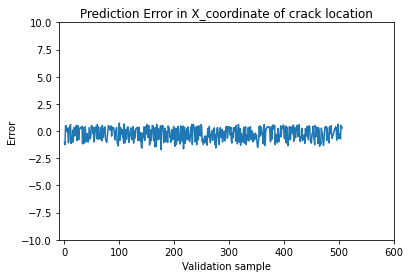

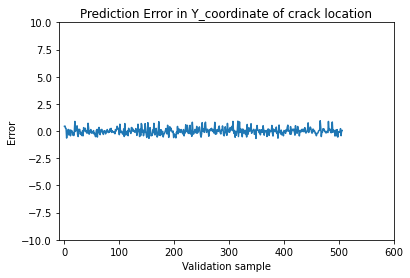

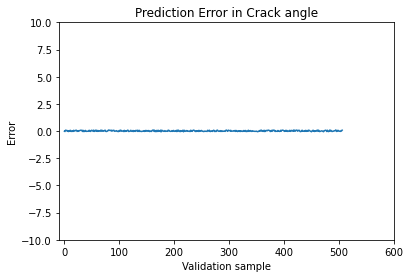

In [6]:
yval_predict = model.predict(xval_scale) ##Model stores the latest updates weights used for prediction
#print (yval_predict)
y_pred = scaler_y.inverse_transform(yval_predict)

val_stack = np.column_stack((y_pred, y_val))


#x_pred = scaler_x.inverse_transform(xval_scale)
#x_error = x_pred - X_val

print(val_stack)
plt.figure(1)
plt.plot(y_pred[:,0]-y_val[:,0])
plt.axis([-10, 600, -10, 10])
plt.title("Prediction Error in X_coordinate of crack location")
plt.xlabel("Validation sample")
plt.ylabel("Error")
plt.savefig('Error_X.png', dpi=300, bbox_inches='tight')

plt.figure(2)
plt.axis([-10, 600, -10, 10])
plt.plot(y_pred[:,1]-y_val[:,1])
plt.title("Prediction Error in Y_coordinate of crack location")
plt.xlabel("Validation sample")
plt.ylabel("Error")
plt.savefig('Error_Y.png', dpi=300, bbox_inches='tight')

plt.figure(3)
plt.axis([-10, 600, -10, 10])
plt.plot(y_pred[:,2]-y_val[:,2])
plt.title("Prediction Error in Crack angle")
plt.xlabel("Validation sample")
plt.ylabel("Error")
plt.savefig('Error_angle.png', dpi=300, bbox_inches='tight')

#plt.plot()